In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from collections import defaultdict
import time

In [64]:
class BlackjackEnvironment:
    def __init__(self, min_bet, max_bet):
        """
        A Blackjack environment that adjusts rewards based on a bet
        determined by the card count.
        """
        self.min_bet = min_bet
        self.max_bet = max_bet

        self.deck = self._create_new_deck()
        self.player_cards = []
        self.dealer_cards = []

        self.has_doubled_down = False
        self.game_over = False

        self.rewards = []
        self.profits = 0  # Cumulative profits
        self.current_bet = self.min_bet
        self.reset_game()

    # def _create_new_deck(self):
    #     suits = ['hearts', 'diamonds', 'clubs', 'spades']
    #     values = list(range(2, 11)) + ['jack', 'queen', 'king', 'ace']
    #     deck = [f"{value}_{suit}" for value in values for suit in suits]
    #     random.shuffle(deck)
    #     return deck
    
    def _create_new_deck(self, num_decks=6):
        suits = ['hearts', 'diamonds', 'clubs', 'spades']
        values = list(range(2, 11)) + ['jack', 'queen', 'king', 'ace']
        deck = [f"{value}_{suit}" for value in values for suit in suits for _ in range(num_decks)]
        random.shuffle(deck)
        return deck


    def _draw_random_card(self):
        return self.deck.pop()

    def reset_game(self):
        """
        Resets for a new round:
        """
        self.deck = self._create_new_deck()
        self.player_cards = [self._draw_random_card(), self._draw_random_card()]
        self.dealer_cards = [self._draw_random_card(), self._draw_random_card()]

        self.has_doubled_down = False
        self.game_over = False

        # Determine the bet for this round from the card count
        self.current_bet = self.calculate_bet()

    def _get_card_value(self, card):
        value = card.split('_')[0]
        if value in ['jack', 'queen', 'king']:
            return 10
        elif value == 'ace':
            return 11
        else:
            return int(value)

    def _calculate_hand_value(self, hand):
        total = sum(self._get_card_value(card) for card in hand)
        # Adjust for Aces if we're over 21
        aces = sum(card.startswith('ace') for card in hand)
        while total > 21 and aces > 0:
            total -= 10
            aces -= 1
        return total

    def _has_soft_hand(self, hand):
        total_without_ace_adjust = sum(
            1 if card.startswith('ace') else self._get_card_value(card)
            for card in hand
        )
        total = self._calculate_hand_value(hand)
        return (total != total_without_ace_adjust)

    def _check_if_busted(self, hand):
        return self._calculate_hand_value(hand) > 21

    def _check_natural_blackjack(self, hand):
        return len(hand) == 2 and self._calculate_hand_value(hand) == 21

    def _play_dealer_hand(self):
        """
        Dealer hits until total is 17 or more (soft 17 rule optional).
        """
        while self._calculate_hand_value(self.dealer_cards) < 17:
            self.dealer_cards.append(self._draw_random_card())

    def _finalize_round(self):
        """
        Compares player's hand vs. dealer's hand to assign final rewards.
        """
        player_value = self._calculate_hand_value(self.player_cards)
        dealer_value = self._calculate_hand_value(self.dealer_cards)

        # If dealer busts, player automatically wins
        if self._check_if_busted(self.dealer_cards):
            reward = (4 if self.has_doubled_down else 1) * self.current_bet
            self.rewards.append(reward)
            self.profits += reward
            return 'terminal', reward, True

        # Compare values
        if player_value > dealer_value:
            # Player wins
            reward = (4 if self.has_doubled_down else 1) * self.current_bet
        elif player_value < dealer_value:
            # Dealer wins
            reward = (-2 if self.has_doubled_down else -1) * self.current_bet
        else:
            # Tie
            reward = 0

        self.rewards.append(reward)
        self.profits += reward
        return 'terminal', reward, True

    def count_hand(self, hand):
        """
        Basic Hi-Lo style counting:

        """
        count = 0
        for card in hand:
            val = self._get_card_value(card)
            if val in [2, 3, 4, 5, 6]:
                count += 1

            elif val == 10 or val == 11:  # Ace = 11 
                count -= 1

        return count

    def calculate_count(self, player_hand, dealer_hand):
        """
        Compute combined count from known cards (player + dealer).
        """
        total_count = self.count_hand(player_hand) + self.count_hand(dealer_hand)
        return total_count

    def calculate_bet(self):
        """
        Decide on a bet for this round based on the card count.
        """
        current_count = self.calculate_count(self.player_cards, self.dealer_cards)
        if current_count >= 2:
            return self.max_bet
        else:
            return self.min_bet
        
    # def calculate_bet(self):
    #     current_count = self.calculate_count(self.player_cards, self.dealer_cards)
    #     if current_count > 0:
    #         scaling_factor = min(current_count, 10) / 10  # Cap scaling to avoid excessive bets
    #         return int(self.min_bet + scaling_factor * (self.max_bet - self.min_bet))
    #     return self.min_bet


    def get_current_state(self):
        player_value = self._calculate_hand_value(self.player_cards)
        dealer_up_card_value = self._get_card_value(self.dealer_cards[0])
        is_soft = self._has_soft_hand(self.player_cards)
        count_info = self.calculate_count(self.player_cards, self.dealer_cards)
        return (player_value, dealer_up_card_value, is_soft, self.has_doubled_down, count_info)

    def step(self, action):
        if self.game_over:
            return 'terminal', 0, True
        if self._check_natural_blackjack(self.player_cards):
            reward = 1.5 * self.current_bet
            self.rewards.append(reward)
            self.profits += reward
            self.game_over = True
            return 'terminal', reward, True

        if action == 'h':
            self.player_cards.append(self._draw_random_card())
            if self._check_if_busted(self.player_cards):
                reward = (-2 if self.has_doubled_down else -1) * self.current_bet
                self.rewards.append(reward)
                self.profits += reward
                self.game_over = True
                return 'terminal', reward, True
            else:
                return self.get_current_state(), 0, False

        elif action == 's':
            self._play_dealer_hand()
            next_state, reward, done = self._finalize_round()
            self.game_over = True
            return next_state, reward, done

        elif action == 'd':
            self.has_doubled_down = True
            self.player_cards.append(self._draw_random_card())
            if self._check_if_busted(self.player_cards):
                reward = -2 * self.current_bet
                self.rewards.append(reward)
                self.profits += reward
                self.game_over = True
                return 'terminal', reward, True
            else:
                self._play_dealer_hand()
                next_state, reward, done = self._finalize_round()
                self.game_over = True
                return next_state, reward, done

        else:
            raise ValueError("Invalid action.")

    def display_profits(self):
        """
        Display cumulative profits.
        """
        print(f"Cumulative Profits: {self.profits}")


Q-learning

In [62]:
#class Qlearning

class QLearningAgent:
      def __init__(self, environment, num_episodes, initial_epsilon, epsilon_decay, final_epsilon, alpha, gamma):
         # initialize the Q-learning agent with the given environment and learning parameters
         self.environment = environment
         self.alpha = alpha  # learning rate
         self.gamma = gamma  # discount factor
         self.initial_epsilon = initial_epsilon  # exploration rate
         self.epsilon = self.initial_epsilon
         self.num_episodes = num_episodes  # number of episodes to train
         self.epsilon_decay = epsilon_decay  # decay rate for epsilon
         self.final_epsilon = final_epsilon
         self.Q_values = {}  # Q-value dictionary mapping (state, action) pairs to Q-values
         self.epsilon_values = []
         self.epsilon = 0
         self.q_table = {}
         self.action_counts = {'h': 0, 's': 0, 'd': 0}
         

      # Method to extract the policy
      def get_policy(self):
         policy = {}
         for state, actions in self.q_table.items():
               # Find the action with the highest Q-value
               best_action = max(actions, key=actions.get)
               policy[state] = best_action
         return policy
      
      def get_q_table(self):
   
         for (state, action), q_value in self.Q_values.items():
            if state == 'terminal':
                  continue 
            if state not in self.q_table:
                  self.q_table[state] = {}
            self.q_table[state][action] = q_value

         return self.q_table
         


      def get_q_value(self, state, action):
      # get the Q-value for a given state-action pair
            return self.Q_values.get((state, action), 0)
   
      def select_action(self, state):
   
         valid_actions = ['h', 's','d']
         if np.random.random() < self.epsilon:
               action = random.choice(valid_actions)   
         else:
               action = max(valid_actions, key=lambda action: self.Q_values.get((state, action), 0))

         self.action_counts[action] += 1  # Increment the count for the selected action
         return action    

      def update_q_value(self, state, action, next_state, reward):
         # update the Q-value table using the Q-learning update rule
         
         current_q = self.get_q_value(state, action)
         next_q = max(self.get_q_value(next_state, a) for a in ['h', 's','d'])
         temporal_difference = reward + self.gamma * next_q - current_q
         self.Q_values[(state, action)] = current_q + self.alpha * temporal_difference


      
      def decay_epsilon(self,num_episode):

         #exp decay
         
         self.epsilon = max(self.final_epsilon, self.initial_epsilon * (self.epsilon_decay ** num_episode))


   
      def train_agent(self, num_episodes):
         # train the Q-learning agent by running the algorithm for the specified number of episodes
         for episode in range(num_episodes):
               self.environment.reset_game()
               state = self.environment.get_current_state()
               done = False
               while not done:
                  action = self.select_action(state)
                  next_state, reward, done = self.environment.step(action)
                  self.update_q_value(state, action, next_state, reward)
                  state = next_state  
               
               
               self.decay_epsilon(num_episode= episode)  # Decay epsilon after each episode
               self.epsilon_values.append(self.epsilon)
         
         print("Action Counts:", self.action_counts)
      

      def train_agent_HP(self, num_episodes):
            rewards = []  # Track rewards
            for episode in range(num_episodes):
                  self.environment.reset_game()
                  state = self.environment.get_current_state()
                  done = False
                  while not done:
                        action = self.select_action(state)
                        next_state, reward, done = self.environment.step(action)
                        rewards.append(reward)
                        self.update_q_value(state, action, next_state, reward)
                        state = next_state 
                  self.decay_epsilon(num_episode= episode)
                  self.epsilon_values.append(self.epsilon)
            if rewards:  
                  return sum(rewards) / len(rewards)  # Average reward
            else:
                  return 0.0  # Return a default value if no rewards
      


hyper parameter tuning - Qlearning

In [6]:
import optuna

# Hyperparameters
num_episodes = 100000
initial_epsilon = 1.0
min_bet =1
max_bet =10
# Initialize the environment and the Q-learning agent
environment = BlackjackEnvironment(min_bet, max_bet)

def objective(trial):
    # Suggest hyperparameters
    final_epsilon = trial.suggest_float("epsilon", 0.05, 0.1, log=True)
    learning_rate = trial.suggest_float("alpha", 0.01, 0.5, log=True)
    discount_factor = trial.suggest_float("gamma", 0.5, 1.0)

    epsilon_decay = (final_epsilon / initial_epsilon) ** (1 / num_episodes)

    # Initialize the Q-learning agent
    agent = QLearningAgent(
        environment=environment,
        num_episodes=num_episodes,
        initial_epsilon=initial_epsilon,
        epsilon_decay=epsilon_decay,
        final_epsilon=final_epsilon,
        alpha=learning_rate,
        gamma=discount_factor,
    )

    # Train the agent and calculate average reward
    average_reward = agent.train_agent_HP(num_episodes)
    return average_reward


start = time.time()
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)
end = time.time()


print("Optimization completed in {:.2f} seconds.".format(end - start))
print("Best parameters:", study.best_params)


[I 2025-01-21 14:43:49,147] A new study created in memory with name: no-name-98fc4d4e-b869-448b-8fc7-2aedef217e7a
[I 2025-01-21 14:44:01,278] Trial 0 finished with value: -0.032580723292814 and parameters: {'epsilon': 0.05547737977420269, 'alpha': 0.09952484761602062, 'gamma': 0.6493719753296444}. Best is trial 0 with value: -0.032580723292814.
[I 2025-01-21 14:44:14,082] Trial 1 finished with value: -0.01637809104897496 and parameters: {'epsilon': 0.05651915757886795, 'alpha': 0.045343041729571064, 'gamma': 0.8115665128191303}. Best is trial 1 with value: -0.01637809104897496.
[I 2025-01-21 14:44:27,017] Trial 2 finished with value: -0.006232243053522108 and parameters: {'epsilon': 0.056461596266632046, 'alpha': 0.011850731444069838, 'gamma': 0.8160087858220451}. Best is trial 2 with value: -0.006232243053522108.
[I 2025-01-21 14:44:39,324] Trial 3 finished with value: -0.0937302372644282 and parameters: {'epsilon': 0.09011503096136139, 'alpha': 0.27222379198662294, 'gamma': 0.8441857

Optimization completed in 636.50 seconds.
Best parameters: {'epsilon': 0.0504862898296134, 'alpha': 0.01130525029479314, 'gamma': 0.5583870823720647}


In [69]:
# training phase
start = time.time()
num_episodes = 100000

learning_rate = 0.01130525029479314
discount_factor = 0.5583870823720647

initial_epsilon = 1.0
final_epsilon = 0.0504862898296134
#epsilon_decay = 0.99998
epsilon_decay = (final_epsilon / initial_epsilon) ** (1 / num_episodes)

min_bet =1
max_bet =10
# Initialize the environment and the Q-learning agent
environment = BlackjackEnvironment(min_bet, max_bet)
agent = QLearningAgent(environment, num_episodes, initial_epsilon, epsilon_decay, final_epsilon, learning_rate, discount_factor)

agent.train_agent(num_episodes)
q_table = agent.get_q_table()
policy = agent.get_policy()


# evaluate the performance of the trained agent over a number of games
num_games = 10000
win_count = 0
loss_count = 0
draw_count = 0
total_reward = 0

for _ in range(num_games):
   
      agent.environment.reset_game()
      state = agent.environment.get_current_state()
      game_done = False

      while not game_done:
         action = agent.select_action(state)
         state, reward, game_done = agent.environment.step(action)
         total_reward += reward
         
      if reward > 0:
         win_count += 1
      elif reward < 0:
         loss_count += 1
      else:
         draw_count += 1

agent.environment.display_profits()
end = time.time()
print(f"Total time: {end-start:0.2f} seconds")
winning_rate = win_count / num_games
losing_rate = loss_count / num_games
draw_rate = draw_count / num_games

print(f"Complete Point Count system - QLearning: Winning rate: {winning_rate:.4f}, Losing rate: {losing_rate:.4f}, Draw rate: {draw_rate:.4f}")




Action Counts: {'h': 38871, 's': 46390, 'd': 38421}
Cumulative Profits: 84399.5
Total time: 4.42 seconds
Complete Point Count system - QLearning: Winning rate: 0.4360, Losing rate: 0.4851, Draw rate: 0.0789


In [109]:
print('Before policy:', policy)


Before policy: {(15, 2, False, False, 1): 's', (19, 2, False, False, 2): 's', (20, 2, False, False, 1): 's', (15, 4, False, False, 1): 's', (12, 10, False, False, -1): 'h', (20, 9, True, False, 0): 's', (17, 10, True, False, -2): 'h', (16, 10, False, False, -2): 'h', (21, 10, False, False, -1): 's', (16, 5, False, False, 0): 's', (13, 9, False, False, -1): 's', (15, 7, False, False, 0): 'd', (14, 11, False, False, 0): 'h', (6, 3, False, False, 2): 'd', (14, 3, False, False, 2): 'd', (9, 10, False, False, 0): 'h', (21, 7, True, False, -3): 'h', (20, 7, False, False, -3): 's', (20, 11, False, False, -2): 's', (8, 3, False, False, 2): 'd', (15, 4, False, False, 0): 'd', (13, 11, True, False, 0): 'd', (11, 9, False, False, 1): 'd', (17, 6, False, False, 0): 's', (14, 2, False, False, 2): 'd', (11, 5, False, False, 3): 'd', (21, 10, True, False, -3): 'h', (15, 7, False, False, 1): 'h', (20, 10, False, False, -3): 's', (20, 8, False, False, -1): 's', (16, 11, False, False, -1): 'h', (7, 2, F

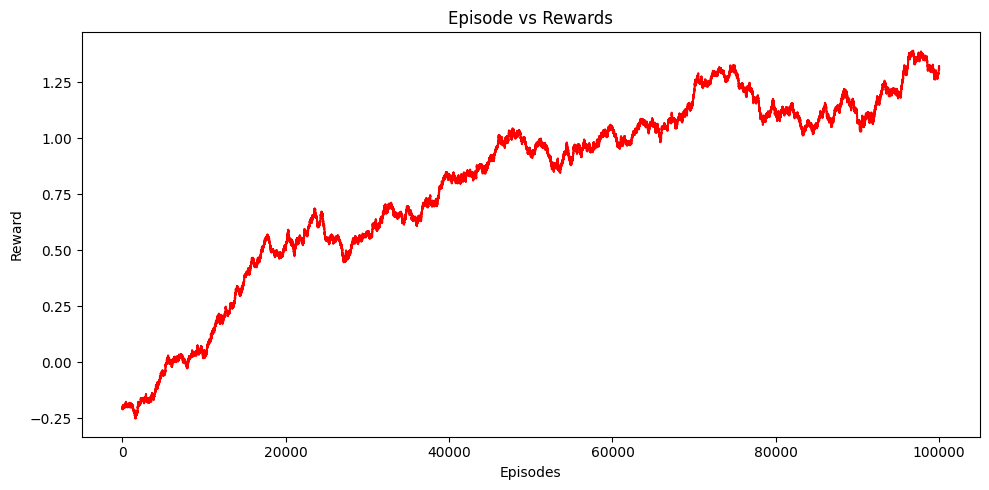

In [70]:


# Plot the reward moving average
length_step = 10000
reward_moving_average = (np.convolve(np.array(agent.environment.rewards).flatten(), np.ones(length_step), mode="valid") / length_step)
plt.figure(figsize=(10, 5))
plt.title('Episode vs Rewards')
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.plot(range(len(reward_moving_average)), reward_moving_average, color='red')
plt.tight_layout()
plt.show()

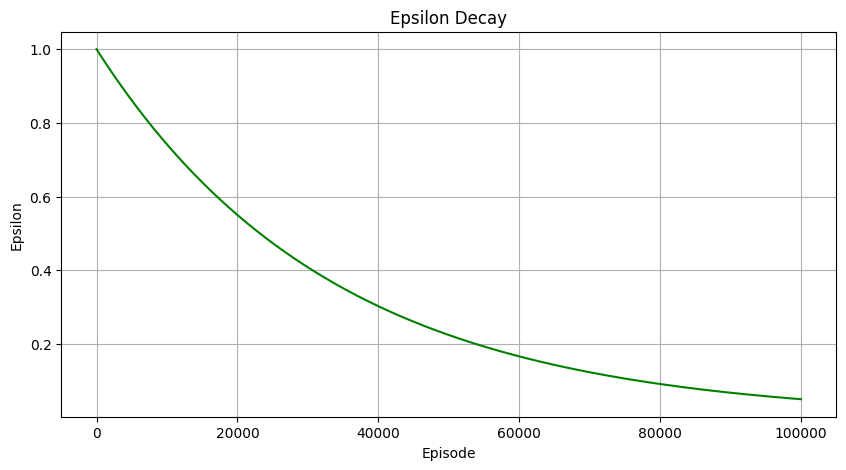

In [71]:
fig, ax = plt.subplots(figsize=(10, 5))

# Plot epsilon values
ax.plot(range(len(agent.epsilon_values)), agent.epsilon_values, color='green')

# Set labels, title, and grid
ax.set_xlabel('Episode')
ax.set_ylabel('Epsilon')
ax.set_title('Epsilon Decay')
ax.grid()

plt.show()

Rule variations

In [72]:
class QLearningAgent_RV:
    def __init__(self, environment, num_episodes, initial_epsilon, epsilon_decay, final_epsilon, learning_rate=0.1, discount_factor=0.99):
        
        self.environment = environment
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.initial_epsilon = initial_epsilon
        self.epsilon = initial_epsilon
        self.num_episodes = num_episodes
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        self.Q_values = defaultdict(lambda: [0, 0,0])
        self.errors = []
        self.epsilon_values = []

        self.q_table = {}
        self.action_map = {'h': 0, 's': 1, 'd': 2}
    

     # Method to extract the policy
    def get_policy(self):
        policy = {}
        for state, actions in self.q_table.items():
            # Find the action with the highest Q-value
            best_action = max(actions, key=actions.get)
            policy[state] = best_action
        return policy
    
     
    def get_q_table(self):
    # Generate a Q-table organized by state and actions
        for state, q_values in self.Q_values.items():
            if state == 'terminal':
               continue 
            if state not in self.q_table:
                self.q_table[state] = {}
            actions = ['h', 's','d'] 
            for action_index, action in enumerate(actions):
                self.q_table[state][action] = q_values[action_index]
        return self.q_table
     
   
    

    def select_action(self, state):
        # choose an action based on the current state
        
    
        if self.environment._has_soft_hand(self.environment.player_cards):
            return self.choose_soft_action(state)
        else: 
            return self.choose_hard_action(state)

    def choose_hard_action(self, state):
      """
      Basic Strategy for Hard Hands (Table 3.1) 
      + Simple Double Down logic.
      """
      player_hand_value = state[0]
      dealer_up_card_value = state[1]
      has_doubled_down = state[3]

      # 1) Check for Double Down opportunities
      #    (In real Blackjack, often limited to two-card totals 9, 10, 11.)
      #    We'll assume we can always double if we meet these totals.
      
      if player_hand_value == 9 and 3 <= dealer_up_card_value <= 6:
            return 'd'
      elif player_hand_value == 10 and 2 <= dealer_up_card_value <= 9:
            return 'd'
      elif player_hand_value == 11 and 2 <= dealer_up_card_value <= 10:
            return 'd'
      
      if player_hand_value <= 11:
         return 'h'
      elif player_hand_value >= 17: 
         return 's'
      elif 12 <= player_hand_value <= 16 and dealer_up_card_value >= 7:
         return 'h'
      elif 12 <= player_hand_value <= 17 and 4 <= dealer_up_card_value <= 6:
         return 's'
      elif 13 <= player_hand_value <= 17 and (dealer_up_card_value == 2 or dealer_up_card_value == 3):
         return 's'
      elif player_hand_value == 12 and (dealer_up_card_value == 2 or dealer_up_card_value == 3):
         return 'h'
      else:
        return 'h'


    def choose_soft_action(self, state):
      """
      Basic Strategy for Soft Hands (Table 3.2) 
      + Simple Double Down logic.
      """
      player_hand_value = state[0]
      dealer_up_card_value = state[1]
      has_doubled_down = state[3]

      # 1) Check for Double Down opportunities on soft totals:
      if player_hand_value in [13, 14]:  # A2, A3 => total 13,14
         if dealer_up_card_value in [5, 6] :
               return 'd'
         else:
               return 'h'
      elif player_hand_value in [15, 16]:  # A4, A5 => total 15,16
         if 4 <= dealer_up_card_value <= 6 :
               return 'd'
         else:
               return 'h'
      elif player_hand_value == 17:  # A6 => total 17
         if 3 <= dealer_up_card_value <= 6:
               return 'd'
         else:
               return 'h'
      elif player_hand_value == 18:  # A7 => total 18
         # Double vs 2..6, stand vs 7,8, hit vs 9,10,A
         if 2 <= dealer_up_card_value <= 6 :
               return 'd'
         elif dealer_up_card_value in [7, 8]:
               return 's'
         else:  # dealer_up_card_value in [9,10,11]
               return 'h'
      if player_hand_value <= 17:
         return 'h'
      elif player_hand_value == 18 and (dealer_up_card_value == 9 or dealer_up_card_value == 10):
         return 'h'
      else:
         return 's'


    def update_q_value(self, state, action, next_state, reward):
         # update the Q-value table using the Q-learning update rule
         action_index = self.action_map[action]
         current_q = self.Q_values[state][action_index]
             
         if next_state == 'terminal':
               next_q = 0.0
         else:
               next_q = max(self.Q_values[next_state])
         
         temporal_difference = reward + self.discount_factor * next_q - current_q
         self.Q_values[state][action_index] += self.learning_rate * temporal_difference
         self.errors.append(temporal_difference)
    
    def decay_epsilon(self, num_episode):
        # decay the epsilon value to reduce exploration over time
        self.epsilon = max(self.final_epsilon, self.initial_epsilon * (self.epsilon_decay ** num_episode))
    
    def train_agent(self, num_episodes):
        # train the Q-learning agent by running the algorithm for the specified number of episodes
        for episode in range(num_episodes):
            self.environment.reset_game()
            state = self.environment.get_current_state()
            game_done = False
            while not game_done:
                action = self.select_action(state)
                next_state, reward, game_done = self.environment.step(action)
                self.update_q_value(state, action, next_state, reward)
                state = next_state

              
            self.decay_epsilon(num_episode= episode)  # Decay epsilon after each episode
            self.epsilon_values.append(self.epsilon)


     

In [116]:
# training phase
start = time.time()
num_episodes = 100000

learning_rate = 0.01130525029479314
discount_factor = 0.5583870823720647

initial_epsilon = 1.0
final_epsilon = 0.0504862898296134
epsilon_decay = (final_epsilon / initial_epsilon) ** (1 / num_episodes)


# Initialize the environment and the Q-learning agent

min_bet =1
max_bet =10
environment = BlackjackEnvironment(min_bet=min_bet, max_bet= max_bet)
agent = QLearningAgent_RV(environment, num_episodes, initial_epsilon, epsilon_decay, final_epsilon, learning_rate, discount_factor)

agent.train_agent(num_episodes)


q_table = agent.get_q_table()
policy_RV = agent.get_policy()


# evaluate the performance of the trained agent over a number of games
num_games = 10000
win_count = 0
loss_count = 0
draw_count = 0
total_reward = 0

for _ in range(num_games):
    
    agent.environment.reset_game()
    state = agent.environment.get_current_state()
    game_done = False

    while not game_done:
        action = agent.select_action(state)
        state, reward, game_done = agent.environment.step(action)
        total_reward += reward
        
    if reward > 0:
        win_count += 1
    elif reward < 0:
        loss_count += 1
    else:
        draw_count += 1

agent.environment.display_profits()
end = time.time()
print(f"Total time: {end-start:0.2f} seconds")

winning_rate = win_count / num_games
losing_rate = loss_count / num_games
draw_rate = draw_count / num_games

print(f"Complete Point Count system - QLearning(Rule variations): Winning rate: {winning_rate:.4f}, Losing rate: {losing_rate:.4f}, Draw rate: {draw_rate:.4f}")



Cumulative Profits: 79753.5
Total time: 4.69 seconds
Complete Point Count system - QLearning(Rule variations): Winning rate: 0.4384, Losing rate: 0.4757, Draw rate: 0.0859


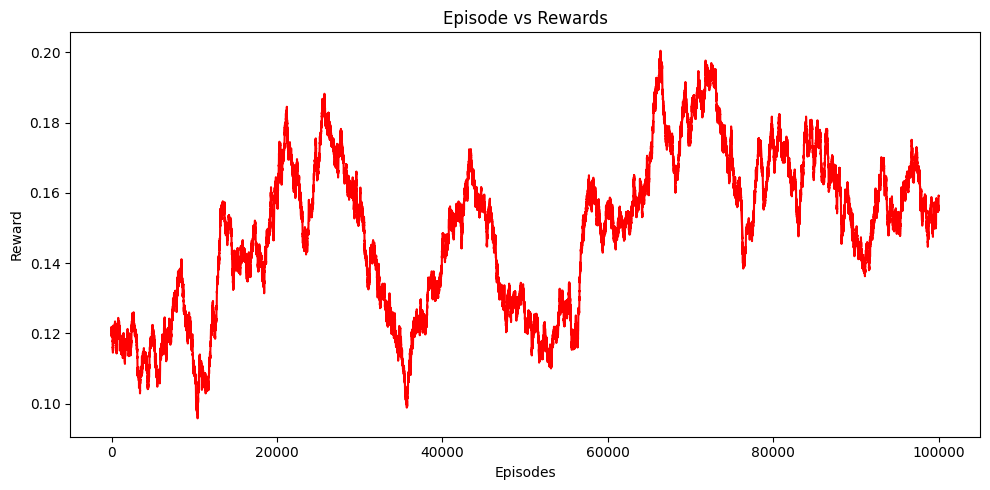

In [23]:
# Plot the reward moving average
length_step = 10000
reward_moving_average = (np.convolve(np.array(environment.rewards).flatten(), np.ones(length_step), mode="valid") / length_step)
plt.figure(figsize=(10, 5))
plt.title('Episode vs Rewards')
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.plot(range(len(reward_moving_average)), reward_moving_average, color='red')
plt.tight_layout()
plt.show()

In [110]:
print("After policy",policy_RV)
#print(len(policy_RV))

After policy {(12, 10, False, False, -1): 's', (16, 10, False, False, 0): 's', (20, 9, False, False, -3): 's', (18, 11, False, False, -1): 'h', (13, 10, False, False, -1): 's', (12, 10, False, False, 1): 's', (20, 5, False, False, -1): 's', (20, 9, False, False, -1): 's', (11, 4, False, False, 2): 'd', (19, 10, False, False, -1): 'h', (15, 5, False, False, 2): 'h', (21, 10, True, False, -4): 's', (13, 9, False, False, 1): 's', (21, 5, True, False, 0): 's', (14, 10, True, False, 0): 'h', (12, 10, False, False, 0): 's', (21, 10, False, False, 0): 's', (15, 3, False, False, 0): 'h', (12, 5, False, False, 3): 'h', (10, 11, False, False, 1): 'h', (18, 11, False, False, 1): 's', (17, 10, False, False, 0): 'h', (14, 7, False, False, 1): 's', (19, 7, False, False, 2): 's', (16, 5, False, False, 0): 's', (20, 3, False, False, 0): 's', (20, 6, False, False, -2): 's', (19, 4, False, False, -1): 's', (20, 10, False, False, -2): 's', (11, 10, False, False, -1): 'h', (18, 10, True, False, -2): 'h', 

SARSA

In [82]:
#SARSA - change in update rule
class SARSAAgent:
    def __init__(self, environment, num_episodes, initial_epsilon, epsilon_decay, final_epsilon, alpha, gamma):
        # initialize the SARSA agent with the given environment and learning parameters
        self.environment = environment
        self.alpha = alpha  # learning rate
        self.gamma = gamma  # discount factor
        self.epsilon = initial_epsilon
        self.initial_epsilon = initial_epsilon  # exploration rate
        self.num_episodes = num_episodes  # number of episodes to train
        self.epsilon_decay = epsilon_decay  # decay rate for epsilon
        self.final_epsilon = final_epsilon
        self.Q_values = {}  # Q-value dictionary mapping (state, action) pairs to Q-values
        self.epsilon_values = []
        self.action_counts = {'h': 0, 's': 0, 'd': 0}
        self.q_table = {}
        

     # Method to extract the policy
    def get_policy(self):
        """
        Derive the policy from the Q-table by selecting the best action for each state.
        """
        policy = {}

        # Ensure the Q-table is populated
        if not hasattr(self, "q_table") or not self.q_table:
            raise ValueError("Q-table is not initialized or empty. Ensure Q-values are populated.")

        for state, actions in self.q_table.items():
            if actions:  # Ensure there are actions to evaluate
                # Find the action with the highest Q-value
                best_action = max(actions, key=actions.get)
                policy[state] = best_action
            else:
                # Handle states with no available actions
                policy[state] = None  # No action is possible

        return policy

    
    def get_q_table(self):
        """
        Generate a Q-table organized by state and actions from the Q-values dictionary.
        """
        for (state, action), q_value in self.Q_values.items():
            if state == 'terminal':  # Skip terminal states
                continue
            if state not in self.q_table:
                self.q_table[state] = {a: 0.0 for a in ['h', 's', 'd']} 
            self.q_table[state][action] = q_value

    




    def get_q_value(self, state, action):
        # get the Q-value for a given state-action pair
        return self.Q_values.get((state, action), 0)
    
    def select_action(self, state):
        # choose an action to take in the given state based on the current Q-values and exploration rate
         if np.random.random() < self.epsilon:
            action = random.choice(['h', 's','d'])
         else:
            action =  max(['h', 's','d'], key=lambda action: self.Q_values.get((state, action), 0))
         
         self.action_counts[action] += 1  # Increment the count for the selected action
         return action    

    def update_q_value(self, state, action, next_state, next_action, reward):
        # Get the current Q-value for the given state-action pair
        current_q = self.Q_values.get((state, action), 0)

        # Get the Q-value for the next state and the next action
        # This is the key difference from Q-learning, where we consider the Q-value of the next action
        next_q = self.Q_values.get((next_state, next_action), 0)
        temporal_difference = reward + self.gamma * next_q - current_q
        self.Q_values[(state, action)] = current_q + self.alpha * temporal_difference

    
    def decay_epsilon(self, num_episode):
        # decay the epsilon value to reduce exploration over time
        self.epsilon = max(self.final_epsilon, self.initial_epsilon * (self.epsilon_decay ** num_episode))
    
    
    def train_agent(self, num_episodes):
        # train the SARSA agent by running the algorithm for the specified number of episodes
         for episode in range(num_episodes):
            self.environment.reset_game()
            state = self.environment.get_current_state()
            action = self.select_action(state)
            done = False
            while not done:
                next_state, reward, done = self.environment.step(action)
                next_action = self.select_action(next_state)
                self.update_q_value(state, action, next_state, next_action, reward)
                state = next_state  
                action = next_action
            
            self.decay_epsilon(num_episode= episode)  # Decay epsilon after each episode
            self.epsilon_values.append(self.epsilon)
         print("Action Counts:", self.action_counts)

    def train_agent_HP(self, num_episodes):
            rewards = []  # Track rewards
            for episode in range(num_episodes):
                  self.environment.reset_game()
                  state = self.environment.get_current_state()
                  action = self.select_action(state)
                  done = False
                  while not done:
                        next_state, reward, done = self.environment.step(action)
                        rewards.append(reward)
                        next_action = self.select_action(next_state)
                        self.update_q_value(state, action, next_state, next_action, reward)
                        
                        state = next_state  
                        action = next_action
                  self.decay_epsilon(num_episode= episode)
                  self.epsilon_values.append(self.epsilon)
            if rewards:  
                  return sum(rewards) / len(rewards)  # Average reward
            else:
                  return 0.0  # Return a default value if no rewards


hyper parameter tuning - SARSA

In [26]:


# Hyperparameters
num_episodes = 100000
initial_epsilon = 1.0
min_bet=1
max_bet=10
environment = BlackjackEnvironment(min_bet=min_bet, max_bet=max_bet)

def objective(trial):
    # Suggest hyperparameters
    final_epsilon = trial.suggest_float("epsilon", 0.05, 0.1, log=True)
    learning_rate = trial.suggest_float("alpha", 0.01, 0.5, log=True)
    discount_factor = trial.suggest_float("gamma", 0.5, 1.0)

    epsilon_decay = (final_epsilon / initial_epsilon) ** (1 / num_episodes)

    # Initialize the Q-learning agent
    agent = SARSAAgent(
        environment=environment,
        num_episodes=num_episodes,
        initial_epsilon=initial_epsilon,
        epsilon_decay=epsilon_decay,
        final_epsilon=final_epsilon,
        alpha=learning_rate,
        gamma=discount_factor,
    )

    # Train the agent and calculate average reward
    average_reward = agent.train_agent_HP(num_episodes)
    return average_reward


start = time.time()
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)
end = time.time()


print("Optimization completed in {:.2f} seconds.".format(end - start))
print("Best parameters:", study.best_params)


[I 2025-01-21 15:08:25,463] A new study created in memory with name: no-name-57f7865f-2937-4889-8b50-779267cd63ef
[I 2025-01-21 15:08:37,846] Trial 0 finished with value: -0.09828632847389376 and parameters: {'epsilon': 0.09786947660196359, 'alpha': 0.2732761679974404, 'gamma': 0.6030251871612211}. Best is trial 0 with value: -0.09828632847389376.
[I 2025-01-21 15:08:50,641] Trial 1 finished with value: -0.020853671119153632 and parameters: {'epsilon': 0.07820308052324094, 'alpha': 0.018265827598364703, 'gamma': 0.5293586111403494}. Best is trial 1 with value: -0.020853671119153632.
[I 2025-01-21 15:09:03,690] Trial 2 finished with value: -0.027376207658263173 and parameters: {'epsilon': 0.08156226284189974, 'alpha': 0.056933311248081264, 'gamma': 0.8688074105741819}. Best is trial 1 with value: -0.020853671119153632.
[I 2025-01-21 15:09:16,655] Trial 3 finished with value: -0.007630233301374241 and parameters: {'epsilon': 0.07243491568162304, 'alpha': 0.011989266589502254, 'gamma': 0.

Optimization completed in 633.90 seconds.
Best parameters: {'epsilon': 0.05098351347681501, 'alpha': 0.012300769827864733, 'gamma': 0.7101134217374672}


In [85]:
# training
start = time.time()
num_episodes = 100000

learning_rate =0.012300769827864733
discount_factor =  0.7101134217374672
initial_epsilon = 1.0
final_epsilon = 0.05098351347681501
epsilon_decay = (final_epsilon / initial_epsilon) ** (1 / num_episodes)

# Initialize the environment and the SARSA agent
min_bet = 1
max_bet = 10
environment = BlackjackEnvironment(min_bet=min_bet, max_bet= max_bet)
agent = SARSAAgent(environment, num_episodes, initial_epsilon, epsilon_decay, final_epsilon, learning_rate,discount_factor)
agent.train_agent(num_episodes)

# evaluate the performance of the trained agent over a number of games
num_games = 10000
win_count = 0
loss_count = 0
draw_count = 0
total_reward = 0

for _ in range(num_games):
    agent.environment.reset_game()
    state = agent.environment.get_current_state()
    game_done = False

    while not game_done:
        action = agent.select_action(state)
        state, reward, game_done = agent.environment.step(action)
        total_reward += reward
    if reward > 0:
        win_count += 1
    elif reward < 0:
        loss_count += 1
    else:
        draw_count += 1

end = time.time()
print(f"Total time: {end-start:0.2f} seconds")

winning_rate = win_count / num_games
losing_rate = loss_count / num_games
draw_rate = draw_count / num_games

print(f"Complete Point count system - SARSA - Winning rate: {winning_rate:.4f}, Losing rate: {losing_rate:.4f}, Draw rate: {draw_rate:.4f}")

Action Counts: {'h': 116626, 's': 57603, 'd': 48631}
Total time: 4.60 seconds
Complete Point count system - SARSA - Winning rate: 0.4318, Losing rate: 0.4929, Draw rate: 0.0753


On- policy Monte Carlo

In [98]:
def epsilon_greedy_action(state, Q, epsilon=0.1):
    """
    Picks an action epsilon-greedily from Q-values for a given state.
    """
    actions = ['h', 's', 'd']  
    # With probability epsilon, choose a random action
    if np.random.rand() < epsilon:
        return random.choice(actions)
    best_action = None
    best_q = float('-inf')
    
    for a in actions:
        q_val = Q.get((state, a), 0.0)
        if q_val > best_q:
            best_q = q_val
            best_action = a
    return best_action

def monte_carlo_control(env, num_episodes=10000, gamma=1.0, epsilon=0.1):
    """
    Monte Carlo Control to learn an optimal policy for Blackjack.
    
    Args:
        env: BlackjackEnvironment instance
        num_episodes: number of episodes to sample
        gamma: discount factor (usually 1.0 for episodic Blackjack)
        epsilon: exploration rate for epsilon-greedy policy
        
    Returns:
        Q: dictionary of state-action values
        policy: derived from Q (greedy w.r.t Q)
    """
    Q = dict()
    

    returns_sum_count = defaultdict(lambda: [0.0, 0]) 
    actions = ['h', 's', 'd']
    
    for episode_i in range(num_episodes):
        env.reset_game()
        episode = []
        state = env.get_current_state()
        done = False
        
        while not done:
            # Select an action via epsilon-greedy
            action = epsilon_greedy_action(state, Q, epsilon)
            next_state, reward, done = env.step(action)
            
            episode.append((state, action, reward))
            state = next_state
        
        # 2) Calculate the returns (G) going backwards
        G = 0.0
        for t in reversed(range(len(episode))):
            s, a, r = episode[t]
            G = gamma * G + r
            
            # Update returns_sum_count
            returns_sum_count[(s, a)][0] += G
            returns_sum_count[(s, a)][1] += 1
            
            # Update Q(s, a) to average of all returns for (s, a)
            Q[(s, a)] = returns_sum_count[(s, a)][0] / returns_sum_count[(s, a)][1]
            
    def policy(state):
        """
        Greedy policy from Q. 
        """
        best_a = None
        best_q_val = float('-inf')
        for a in actions:
            q_val = Q.get((state, a), 0.0)
            if q_val > best_q_val:
                best_q_val = q_val
                best_a = a
        return best_a
    
    return Q, policy


In [107]:
# Train the agent
min_bet=1
max_bet =10 
env = BlackjackEnvironment(min_bet= min_bet, max_bet= max_bet)
start = time.time()
Q, learned_policy = monte_carlo_control(env, num_episodes=100000, gamma=1.0, epsilon=0.1)

def evaluate_policy(env, policy, num_episodes=10000):
    wins, losses, draws = 0, 0, 0
    for _ in range(num_episodes):
        env.reset_game()
        state = env.get_current_state()
        done = False
        while not done:
            action = policy(state)  # purely greedy choice
            state, reward, done = env.step(action)
        
        if reward > 0:
            wins += 1
        elif reward < 0:
            losses += 1
        else:
            draws += 1
    
    return wins / num_episodes, losses / num_episodes, draws / num_episodes

win_rate, loss_rate, draw_rate = evaluate_policy(env, learned_policy)
end = time.time()
print(f"Total time: {end-start:0.2f} seconds")
print(f"After MC training(on policy) Complete point count system:")
print(f"Win Rate:  {win_rate:.4f}")
print(f"Loss Rate: {loss_rate:.4f}")
print(f"Draw Rate: {draw_rate:.4f}")


Total time: 4.27 seconds
After MC training(on policy) Complete point count system:
Win Rate:  0.4381
Loss Rate: 0.4890
Draw Rate: 0.0729
